# Лекция 10. Многозадачность, управление процессами.

1. Основные понятия: программы, процессы, потоки, многозадачность.
2. Основные характеристики процесса.
3. Запуск процессов с помощью execve.
4. Системный вызов fork, комбинирование с execve. Процессы зомби.
5. Ожидание завершения дочернего процесса.

## 1. Основные понятия: программы, процессы, потоки, многозадачность.

**Программа(бинарный модуль)** - это компилированный, исполняемый код, находящийся в каком-либо хранилище данных, например на диске. 

Все наши исполняемые файлы являются для операционной системы Linux программами. Например, почти любая команда в командной строке соответствует определенному исполняемому файлу:

|Команда|Файл|
|-------|----|
|pwd|/bin/pwd|
|ls|/bin/ls|
|cp|/bin/cp|
|mv|/bin/mv|
|rm|/bin/rm|
|mkdir|/bin/mkdir|
|chmod|/bin/chmod|
|cat|/bin/cat|

(Исключение составляет, например, команда cd, которая является встроенной командой bash)

Большие бинарные модули мы часто также называем  **nрuложениями**. 

**Процессом** является запущенная программа. Процесс включает в себя бинарный образ, загружаемый в память, и многое другое: подгрузку виртуальной памяти, ресурсы ядра, например открытые файлы, выполнение требований по безопасности (к примеру, выбор определенного пользователя), а также запуск одного или нескольких потоков. 

**Поток** - это одно из действий внутри процесса, он создается для хранения данных о выполнении кода процесса. Один поток создается всегда автоматически после создания процесса, он называется **главным или первичным потоком**. Первичный поток может создавать еще потоки, которые в свою очередь создавать потоки еще. Все потоки существуют в одном виртуальном адресном пространстве, т.е. разделяют одну память – могут пользоваться одними и теми же данными. 

Если в процессе поток только один, то процесс и является потоком. У него только один экземпляр виртуальной памяти. В многопоточных процессах потоков несколько. 

Операционная система Linux, как известно, **многозадачная** - это означает, что в ней одновременно может выполняться несколько процессов. 

Для многозадачности необязательно наличие нескольких процессоров (ядер процессора), хотя и желательно. Вычислительная система может иметь всего один процессор, что не мешает само по себе реализации режима многозадачности. Так или иначе, количество процессоров в системе в общем случае меньше количества одновременно выполняемых программ (процессов). 

Процессор в каждый момент времени может выполнять только одну программу, а понятие одновременного выполнения нескольких программ вводится через следующее определение:

**Два процесса называются выполняемыми одновременно, если периоды их выполнения (временной отрезок с момента запуска до момента
завершения каждого процесса) полностью или частично перекрываются.**

Иными словами, если процессор, работая в каждый момент времени с одним процессом, при этом переключается между несколькими процессами, уделяя внимание то одному из них, то другому, эти процессы выполняются одновременно.

Переключаться с одной задачи на другую можно разными способами. В настоящее время наибольшее распространение получил  **режим разделения времени**.

В этом режиме каждой задаче отводится определенное время работы, называемое **квантом времени**. По окончании этого кванта, если в системе имеются другие готовые к исполнению процессы, активный процесс принудительно приостанавливается и заменяется другим процессом. Приостановленный процесс помещается в очередь процессов, готовых к выполнению и находится там, пока остальные процессы отработают свои кванты времени; затем он снова получает очередной квант времени для работы, и т. д. 

Если активный процесс затребовал операцию ввода-вывода, он переводится в состояние **блокировки** (ожидания результата ввода-вывода). Процессы, находящиеся в состоянии блокировки, не ставятся в очередь на выполнение и не получают квантов времени до
тех пор, пока операция ввода-вывода не будет завершена (либо не исчезнет другая причина блокировки), и процесс не перейдет в состояние готовности к выполнению.

Существуют различые алгоритмы поддержки очереди на выполнение, в том числе и такие, в которых процессам приписывается некоторый приоритет, выраженный числом. 

Например, в ОС Unix обычно процесс имеет две составляющие приоритета: **статическую и динамическую**.

Статическая составляющая представляет собой заданный администратором уровень важности выполнения данной конкретного процесса, динамическая же изменяется планировщиком: пока процесс находится в стадии выполнения, его динамический приоритет падает, когда же процесс находится в очереди на исполнение, динамическая составляющая приоритета, напротив, растёт. Из нескольких готовых к исполнению пароцессов выбирается имеющий наибольшую сумму приоритетов, так что рано или поздно процесс даже с самым низким статическим приоритетом получит управление за счет возросшего динамического приоритета.

Некоторые операционные системы, включая ранние версии Windows, применяли другую стратегию: в этих системах задачам выделялся квант времени, как и в системах разделения времени, но принудительной смены текущей задачи по истечении кванта времени не производилось; система проверяла, не истек ли квант времени у текущей задачи, только когда задача обращалась к операционной системе за какими-либо услугами (не обязательно за вводом-выводом). Таким образом, задача, не нуждающаяся в услугах операционной системы, могла оставаться на процессоре сколь угодно долго. Такой режим работы называется **невытесняющим**. В современных системах он не применяется, поскольку налагает слишком жесткие требования на исполняемые в системе программы; так, в ранних версиях Windows любая программа, занятая длительными вычислениями, блокировала работу всей системы.

Иногда режим разделения времени также оказывается непригоден. В некоторых ситуациях, таких как управление полетом самолета, ядерным реактором, автоматической линией производства и т. п., некоторые задачи должны быть завершены строго до определенного момента времени; так, если автопилот самолета, получив сигнал от датчиков тангажа и крена, потратит на вычисление необходимого корректирующего воздействия больше времени, чем допустимо, самолет может вовсе потерять управление.

В случае, когда выполняемые процессы (как минимум некоторые из них) имеют жесткие рамки по необходимому времени завершения, применяются **операционные системы реального времени**. 

В отличие от систем разделения времени, задача планировщика реального времени не в том, чтобы дать всем программам
отработать некоторое время, а в том, чтобы обеспечить завершение каждого процесса за отведённое ему время, если же это невозможно, то снять процесс, освободив процессор для тех процессов, которые ещё можно успеть завершить к сроку.


## 2. Основные характеристики процесса.

Любой процесс обладает уникальным идентификатором процесса, который представляет собой целое положительное число (**process ID, обычно сокращается до pid**). Поскольку идентификатор процесса — это единственный широко используемый идентификатор, уникальность
которого гарантируется системой, он часто присоединяется к другим идентификаторам для придания им уникальности. Например, приложения иногда включают идентификатор процесса в имена файлов, чтобы обеспечить их уникальность.

Но, несмотря на уникальность, идентификаторы процесса могут использоваться многократно. По завершении процесса его идентификатор может использоваться повторно для другого процесса. Однако в большинстве версий UNIX реализованы специальные алгоритмы, позволяющие отложить повторное использование идентификатора на более позднее время, чтобы вновь созданный процесс не получил идентификатор процесса, завершившегося совсем недавно. Это помогает избежать ситуации, когда новый процесс по ошибке может быть принят за предыдущий при использовании того же самого идентификатора.

Существует ряд специальных процессов, определяемых конкретной реализацией. **Процесс с идентификатором 0 — это, как правило, процесс-планировщик, который часто называют swapper (программа подкачки). Этому процессу не соответствует
никакая программа на диске, поскольку он является частью ядра и считается системным процессом**.

**Процесс с идентификатором 1 — это обычно процесс init, который запускается ядром в конце процедуры начальной загрузки.** В старых версиях UNIX этому процессу соответствует программа /etc/init, в более новых версиях — /sbin/init. Этот процесс отвечает за запуск операционной системы после загрузки ядра. Обычно init читает системные файлы инициализации — /etc/ или /etc/inittab, а также файлы, расположенные в каталоге /etc/init.d, и переводит систему в некоторое состояние, например в многопользовательский
режим. Процесс init никогда не «умирает». Это обычный пользовательский процесс, он не является системным процессом ядра, как swapper, хотя и обладает привилегиями суперпользователя. 

Процесс init становится родительским процессом любого осиротевшего дочернего процесса.

В Mac OS X 10.4 на смену процессу init пришел процесс launchd, выполняющий тот же комплекс задач, но имеющий более широкие функциональные возможности. 

Если пользователь не указывает ядру напрямую, какой процесс следует запускать (с помощью init в командной строке), ядро выбирает подходящий процесс инициализации самостоятельно — нечастый случай, когда политику диктует ядро. Ядро Linux перебирает четыре исполняемых модуля в следующем порядке.
1. /sbin/init — предпочтительное и наиболее вероятное размещение процесса инициализации.
2. /etc/init — следующее наиболее вероятное размещение процесса инициализации.
3. /bin/init — резервное размещение процесса инициализации.
4. /bin/sh — местонахождение оболочки Bourne, которую ядро пытается запустить, если найти процесс инициализации не удалось.

Первый из этих процессов, который будет существовать, и запустится в качестве процесса инициализации. Если не удалось запустить ни один из четырех, то ядро Linux переводит систему в состояние «паники».

После запуска процесс инициализации отрабатывает оставшуюся часть загрузки. Как правило, в нее включены инициализация системы, запуск различных сервисов и программы авторизации.

Максимальное значение pid хранится в файле **/proc/sys/kernel/pid_max** и может быть изменено администратором:

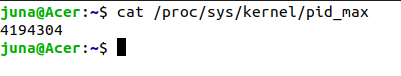

Идентификаторы назначаются ядром строго линейно. Ядро не назначает использованные ранее идентификаторы процессов, пока не пройдет верхнее значение, то есть меньшие значения не будут устанавливаться, пока не будет достигнута величина, записанная в /proc/sys/kernel/pid_max. Таким образом, Linux не гарантирует уникальность идентификаторов процессов на длинные периоды, но тем не менее есть некоторая уверенность, что в течение коротких отрезков времени идентификаторы будут стабильными и уникальными.

Процесс, запускающий другой процесс, называется **родительским**; новый процесс, таким образом, является **дочерним**. Каждый процесс запускается каким-либо другим процессом (кроме, разумеется, процессов инициализации). 

Таким образом, каждый дочерний процесс имеет «родителя». Эти взаимоотношения записаны в каждом идентификаторе родительского процесса (ppid), значение которого для дочернего процесса равно значению pid родительского процесса.

**Каждый процесс принадлежит определенному пользователю и группе**. Эти принадлежности используются для управления правами доступа к ресурсам. С точки зрения ядра пользователь и группа — это просто некие целочисленные величины. Они хранятся в файлах /etc/passwd и /etc/group, с помощью которых сопоставляются с привычными именами, воспринимаемыми человеком. 

**Каждый дочерний процесс наследует пользователя и группу, которым принадлежал родительский процесс.**

**Каждый процесс является также частью группы процессов, которая означает, по сути, его отношение к другим процессам (не следует путать группу процессов с упомянутыми выше пользователем и группой!)**. 

Дочерние процессы, как правило, принадлежат к тем же группам процессов, что и родительские.

Таким образом, в дополнение к идентификатору процесса каждый процесс обладает еще рядом идентификаторов. Вот системные вызовы, которые возвращают эти идентификаторы:

- Возвращает идентификатор процесса
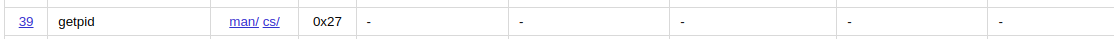
- Возвращает идентификатор родительского процесса:
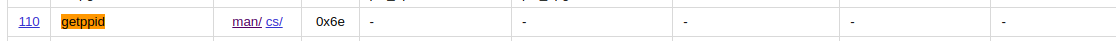
- Возвращает реальный идентификатор пользователя, вызвавшего процесс
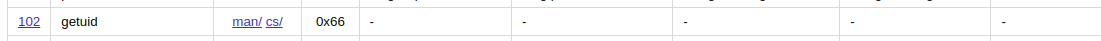
- Возвращает эффективный идентификатор пользователя, вызвывшего процесс
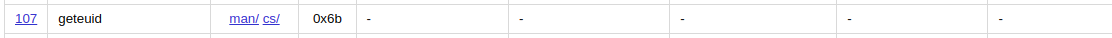
- Возвращает реальный идентификатор группы, вызвавщей процесс
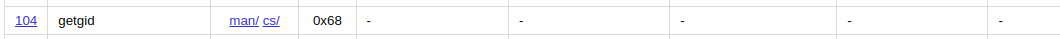
- Возвращает эффективный идентификатор группы, вызвавщей процесс
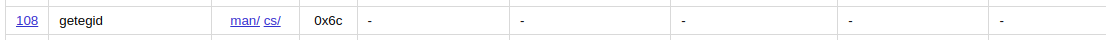

Назначение реальных и эффективных идентификаторов мы рассмотрим позже.

Рассмотрим программу, в которой реализуются все рассмотренные системные вызовы.

Ниже представлены программы на языках C и ассемблере (в ассемблере для удобства использованы функции С printf, getchar):

In [ ]:
/* pids_c.c */
#include <sys/types.h>
#include <unistd.h>
#include <stdio.h>

int main(){
  printf ("pid=%d\n", getpid());
  printf ("ppid=%d\n", getppid());
  printf ("uid=%d\n", getuid());
  printf ("euid=%d\n", geteuid());
  printf ("gid=%d\n", getgid());
  printf ("egid=%d\n", getegid());
  getchar();
  return 0;
}

In [ ]:
	;; pids.asm
	
	format elf64

	public _start

	extrn printf
	extrn getchar

	include "func.asm"

	section '.data' writable
	getpid db "pid: %jd", 0xa, 0
	getppid db "ppid: %ld", 0xa, 0
	getuid db "uid: %jd", 0xa, 0
	geteuid db "euid: %jd", 0xa, 0
	getgid db "gid: %jd", 0xa, 0
	getegid db "egid: %jd", 0xa, 0

	section '.text' executable
	
_start:
	;; Получаем и печатаем pid
	mov rax, 39
	syscall
	mov rdi, getpid
	mov rsi, rax
	call printf

	;; Получаем и печатаем ppid
	mov rax, 110
	syscall
	mov rdi, getppid
	mov rsi, rax
	call printf

	;; Получаем и печатаем uid
	mov rax, 102
	syscall
	mov rdi, getuid
	mov rsi, rax
	call printf

	;; Получаем и печатаем euid
	mov rax, 107
	syscall
	mov rdi, geteuid
	mov rsi, rax
	call printf

	;; Получаем и печатаем gid
	mov rax, 104
	syscall
	mov rdi, getgid
	mov rsi, rax
	call printf

	;; Получаем и печатаем egid
	mov rax, 108
	syscall
	mov rdi, getegid
	mov rsi, rax
	call printf


	;; Ожидаем ввода любого символа и заканчиваем работу
	call getchar
	call exit

Ниже представлен Makefile для удобной сборки исполняемых файлов:

In [ ]:
asm_pids: pids.asm
	fasm pids.asm

comp_pids: asm_pids
	ld pids.o -lc -dynamic-linker /lib64/ld-linux-x86-64.so.2 -o pids

run_pids: comp_pids
	./pids

clear:
	rm -f ./pids ./pids.o ./pids_c

comp_pids_c: pids.c
	gcc pids.c -o pids_c

run_pids_c: comp_pids_c
	./pids_c

Ниже представлен скриншот, демонстрирующий работу:

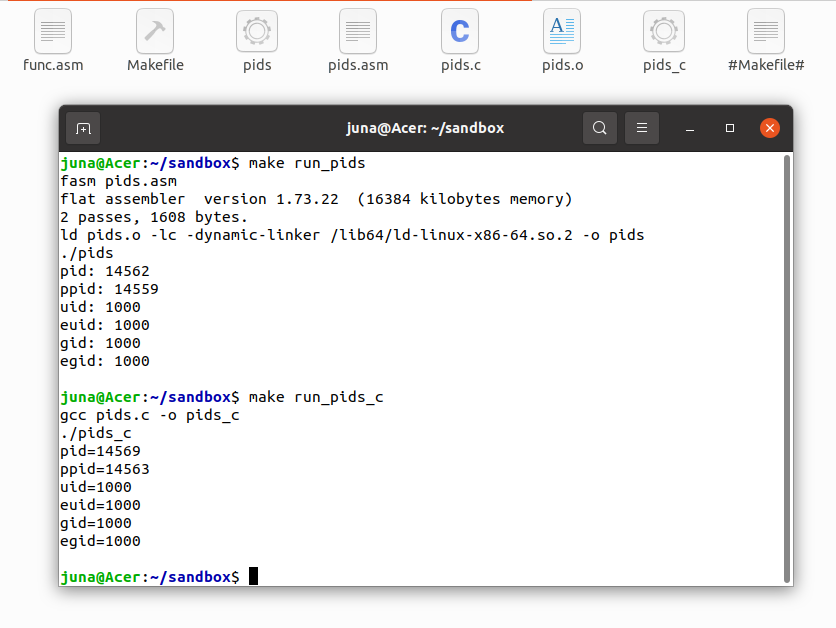

 ## 3. Запуск процессов с помощью execve.

Одним из самых простых способов, позволяющих запускать другие процессы из текущего процесса, использовать **системный вызов execve**.

Когда процесс делает системный вызов **exeсve**,он полностью замещается другой программой (которая запускается), и эта новая программа начинает выполнение со своей собственной точки входа. Идентификатор **PID** процесса при этом не изменяется, поскольку функция **execve** не создает новый процесс, она просто замещает текущий процесс — его сегмент кода, сегмент данных, динамическую область памяти и сегмент стека — другой программой.
В С существует семь различных функций класса **exec**, но только одна из них действительно реализована в виде системного вызова:

In [ ]:
#include <unistd.h>

int execl(const char *pathname, const char *arg0, ... /* (char *)0 */ );

int execv(const char *pathname, char *const argv[]);

int execle(const char *pathname, const char *arg0, ...
 /* (char *)0, char *const envp[] */ );
 
int execve(const char *pathname, char *const argv[], char *const envp[]);

int execlp(const char *filename, const char *arg0, ... /* (char *)0 */ );

int execvp(const char *filename, char *const argv[]);

int fexecve(int fd, char *const argv[], char *const envp[]);

Все семь функций возвращают -1 в случае ошибки, не возвращают управление в случае успеха

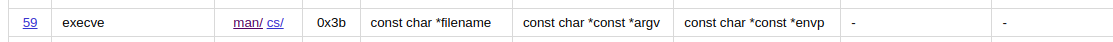

Системный вызов **execve** выполняет программу, указанную в pathname, pathname должен быть либо исполняемым двоичным файлом, либо скриптом, запускающимся строкой вида:
> #! интерпретатор необязательные аргументы

argv — массив указателей на строки, переданные новой программе как ее аргументы командной строки. По соглашению, первый из них (т.е. argv[0] ) имя запускаемой программы. Массив argv должен быть завершен нулевым указателем. 

envp — это массив указателей на строки окружения в форме ключ = значение, которые передаются новой программе. Массив envp должен заканчиваться нулевым указателем. Если третий параметр равен нулю (NULL), то это означает, что запускаемая программа имеет то
же окружение, что и запускающая. Чаще всего выбирается именно этот вариант.


Ниже демонстрируется использование системного вызова **execve**.

In [ ]:
	;; execve.asm
	
	format elf64

	public _start

	include 'func.asm'

	section '.bss' writable
	buffer dq 2

	section '.text' executable
	
_start:
	mov rcx, [rsp]
	cmp rcx, 1
	je ext
	cmp rcx, 2
	je n1
	cmp rcx, 3
	je n2
	jmp ext
n1:	
	mov rax, 59
    mov rsi, 0
	mov rdi, [rsp+16]
	syscall
n2:
	mov rdi, [rsp+16]
	mov [buffer], rdi
	mov rax, [rsp+24]
	mov [buffer+8],rax
	mov rsi, buffer
	mov rax, 59
	syscall
ext:
	call exit

Приведенная программа позволяет запускать консольные программы без параметра или с одним параметром. В качестве первого примера программа запускает консольный калькулятор **bc**, в качестве второго примера запускается shell-скрипт с одним параметром - скрипт создает вложенные папки с именем "p" друг в друга в количестве, заданном параметром скрипта. Ниже приведен также код этого скрипта. 

In [ ]:
#!/bin/bash

for i in $(seq 1 $1)
do
  mkdir p
  cd p
done

exit

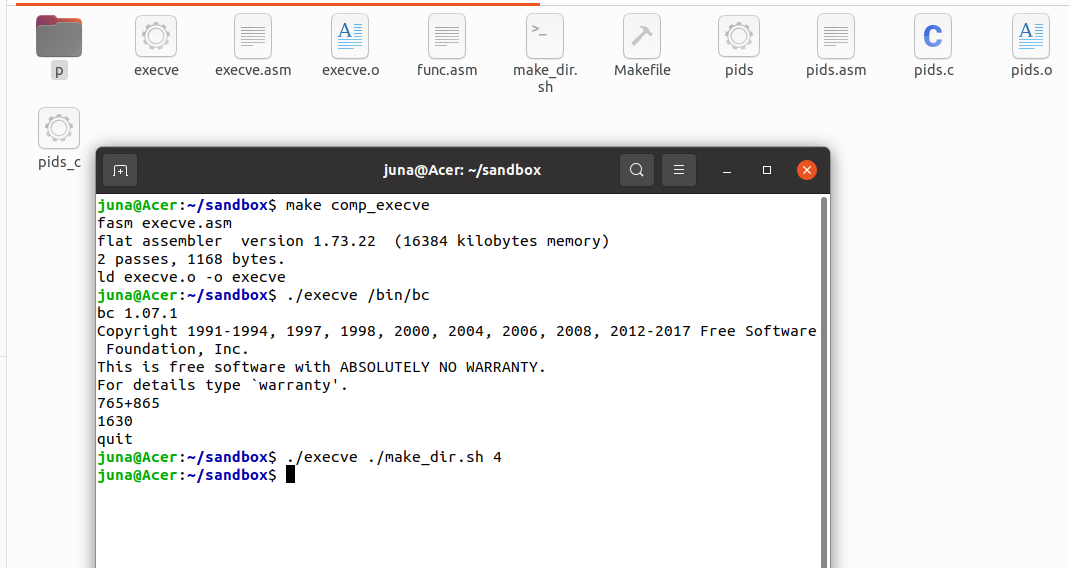

Рассмотренная нами функция **execve** замещает запускающее приложение новым процессом. При этом старое приложение просто теряется. Конечно, хотелось бы иметь механизм, позволяющий не только запускать другие приложения, но сохранять и старые, более того, иметь
возможность управлять запущенными приложениями. 

## 4. Системный вызов fork, комбинирование с execve.

Новый процесс, запускающий тот же исполняемый файл, что и текущий, может быть создан с помощью системного вызова **fork**:

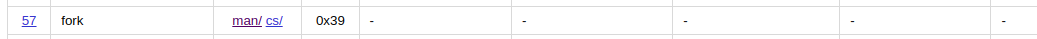

In [ ]:
#include <sys/types.h>
#include <unistd.h>
pid_t fork (void);

В случае успешного обращения к **fork()** создается новый процесс, во всех отношениях идентичный вызывающему. Оба процесса выполняются от точки обращения к **fork()**, как будто ничего не происходило.

Новый процесс является дочерним по отношению к вызывающему, который, в свою очередь, называется родительским. 

**В дочернем процессе успешный запуск fork() возвращает 0. В родительском fork() возвращает pid дочернего.** 

Родительский и дочерний процессы практически идентичны, за исключением некоторых особенностей:
- pid дочернего процесса, конечно, назначается заново и отличается от родительского;
- родительский pid дочернего процесса установлен равным pid родительского процесса;
- ресурсная статистика дочернего процесса обнуляется;
- любые ожидающие сигналы прерываются и не наследуются дочерним процессом; 
- никакие вовлеченные блокировки файлов не наследуются дочерним процессом.
В случае ошибки дочерний процесс не создается, **fork()** возвращает -1, устанавливая соответствующее значение errno.

Чаще всего системный вызов **fork()** используется для создания нового процесса и последующей загрузки в него нового двоичного образа. Т.е. сначала процесс ответвляет новый процесс, а потом дочерний процесс создает новый двоичный образ. Сочетание **fork** и **exec** используется довольно часто.

В приведеном ниже коде вначале создается fork процесса, после чего каждый процесс печатает - кто он: родитель или ребёнок, а также сообщает свои pid и ppid.

Для того, чтобы различить, какой это процесс - родительский или дочерний, достаточно проанализировать rax после fork. Если rax=0, то это дочерний процесс, иначе это родительский процесс.

Тот факт, что родительский процесс может закончить свою работу никак не влияет на работу дочернего процесса. 

Просто если родительский процесс заканчивает работу раньше, то для дочернего процесса родительским становится их прародитель в
операционной системе Linux это **systemd**.

In [ ]:
	;; pids_fork.asm
	
	format elf64

	public _start

	extrn printf
	extrn getchar

	include "func.asm"

	section '.data' writable
	getpid db "pid: %d", 0xa, 0
	getppid db "ppid: %d", 0xa, 0
	msg1 db "I'm the parent", 0xa, 0
	msg2 db "I'm the children",0xa, 0

	section '.bss' writable

	pr db 1
	
	section '.text' executable
	
_start:
	mov rax, 57
	syscall
	cmp rax, 0
	je l1
	mov al, 1
	mov [pr], al
	jmp lloop

l1:
	mov al, 0
	mov [pr], al
lloop:
	xor rax, rax
	mov al, [pr]
	cmp rax, 1
	je ll1
	mov rdi, msg2
	call printf
	jmp ll2
ll1:
	mov rdi, msg1
	call printf
ll2:	
	;; Получаем и печатаем pid
	mov rax, 39
	syscall
	mov rdi, getpid
	mov rsi, rax
	call printf

	;; Получаем и печатаем ppid
	mov rax, 110
	syscall
	mov rdi, getppid
	mov rsi, rax
	call printf


	;; Ожидаем ввода любого символа и заканчиваем работу

	call getchar
	cmp rax, 'q'
	jne lloop
	call exit

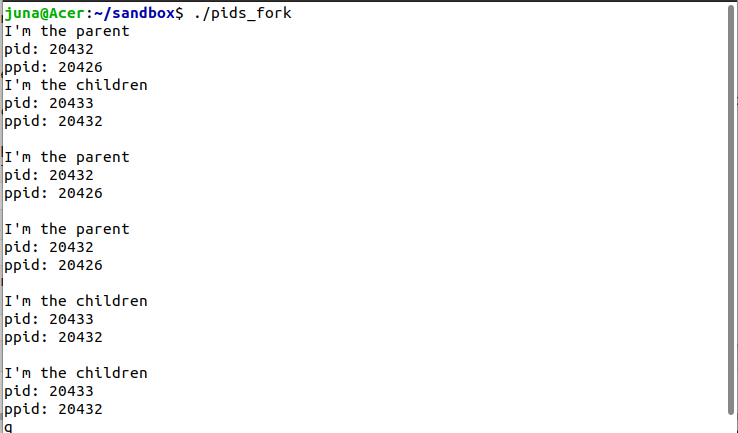
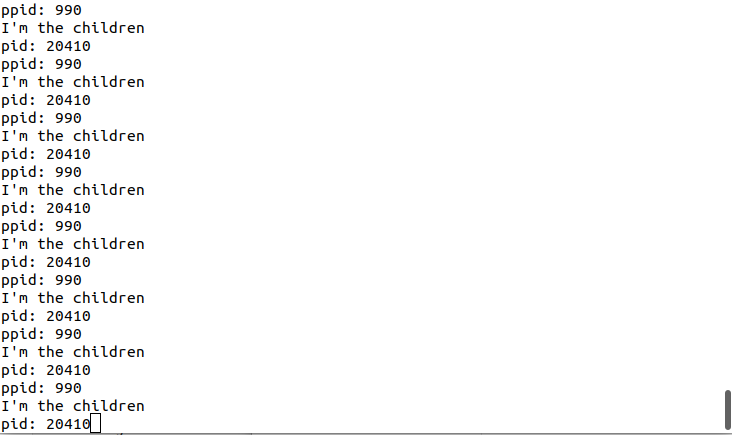
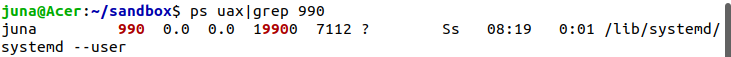

В следующей программе родительский процесс ожидаем от пользователя нажатия клавиши:
- Если пользователь нажимает клавишу "1", то создается дочерний процесс (fork родительского) и с этого места дочерний процесс заменяется на script1.sh (execve);
- Если пользователь нажимает клавишу "2", то создается дочерний процесс (fork родительского) и с этого места дочерний процесс заменяется на script2.sh (execve);
- Если пользователь нажимает клавишу "4", то родительский процесс завершает свою работу.
- Любые другие действия пользователя возвращают родительский процесс в режим ожидания ввода. 

In [ ]:
	;; fork_exec.asm
	
	format elf64

	public _start
	
	include "func.asm"


	section '.data' writable
	
	b1 db "./script1.sh",0
	b2 db "./script2.sh", 0

	msg1 db "1 - script1.sh", 0xa, 0
	msg2 db "2 - script2.sh",0xa, 0
	msg3 db "3 - exit",0xa, 0
	
	section '.bss' writable
	
	buffer rd 100

	
	section '.text' executable
	
_start:
	
   main_loop:	
   
   ;;Выводим сообщения
	mov rsi, msg1
	call print_str
	call new_line
	mov rsi, msg2
	call print_str
	call new_line
	mov rsi, msg3
	call print_str
	call new_line
	
   ;;Читаем введенный символ с клавиатуры и анализиоуем ввод
	mov rsi, buffer
	call input_keyboard
	
	xor rax, rax
	mov al, byte [buffer]
	
	cmp rax, '1'
	je l1

	cmp rax, '2'
	je l2

	cmp rax, '3'
	je l3
   jmp main_loop

   l1:
     ;;Создаем fork и анализируем какой это процесс 
	mov rax, 57
	syscall
	cmp rax, 0
      ;;Если это родительский процесс, возвращаемся в главный цикл
	jne main_loop
	mov rsi, 0
      ;;Если это дочерний процесс, запускаем с помощью execve script1.sh
	mov rdi, b1
	mov rax, 59
	syscall

   l2:
     ;;Аналогично предыдущему, создаем fork и анализируем, какой это процесс
	mov rax, 57
	syscall
	cmp rax, 0
	jne main_loop
	mov rsi, 0
	mov rdi, b2
	mov rax, 59
	syscall
   l3:	
	call exit

Содержание скриптов script1.sh, script2.sh представлено ниже:

In [ ]:
#!/bin/bash

echo "The file1 created"
ls -la > file1

exit

In [ ]:
#!/bin/bash

echo "The file2 created"
ps uax > file2

exit

Ниже представлены скриншоты, демонстрирующие работоспособность программы.

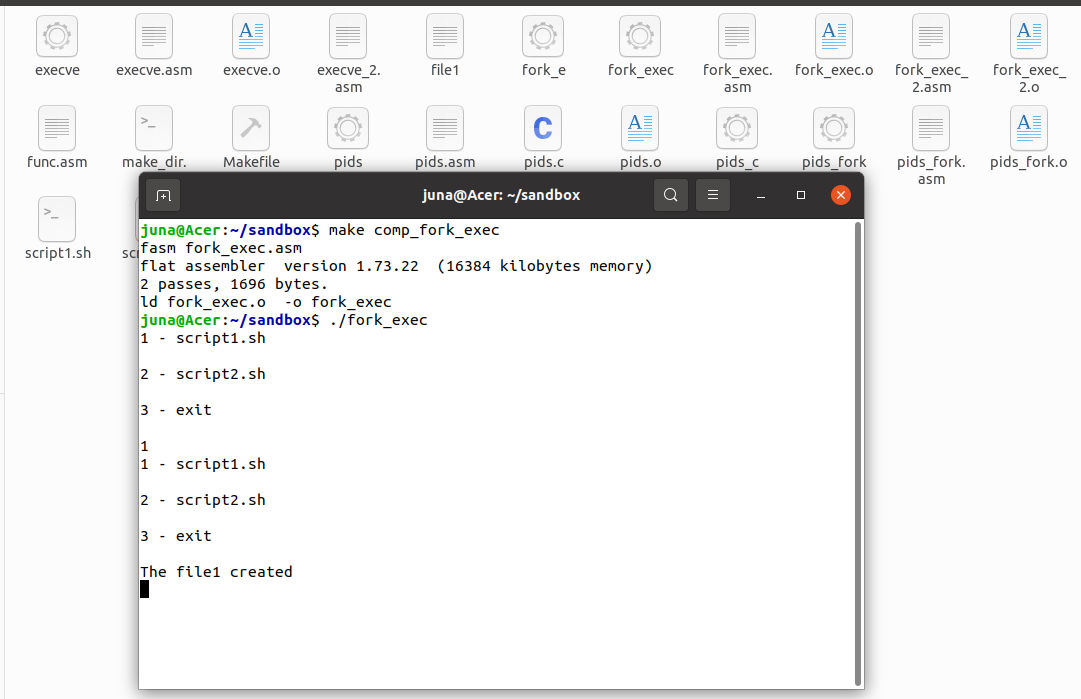

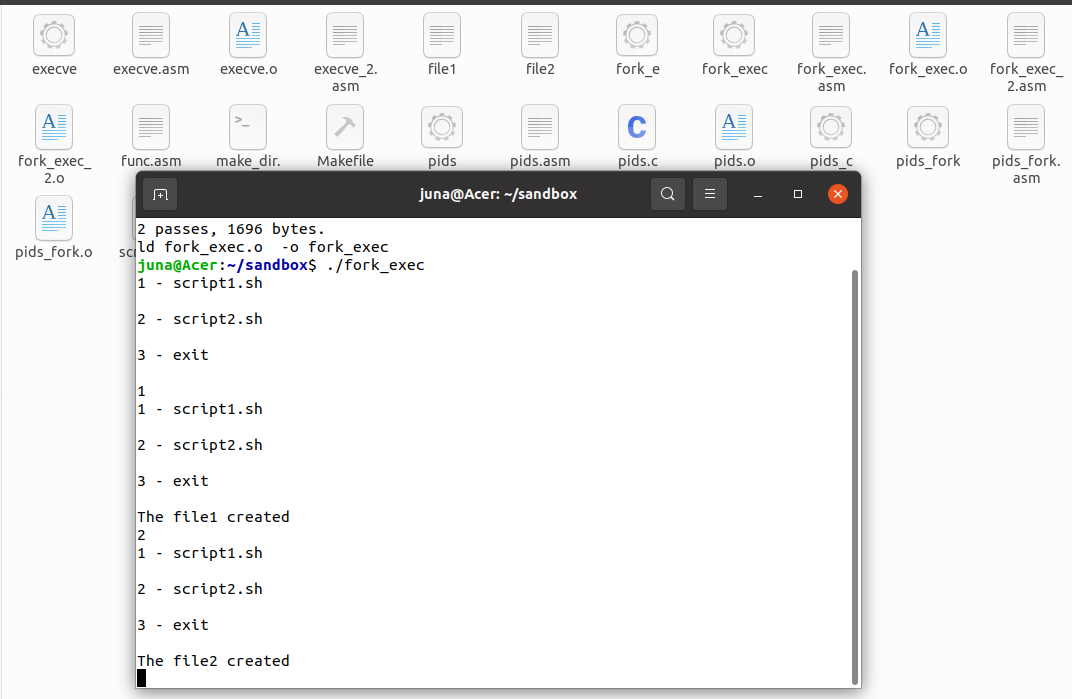

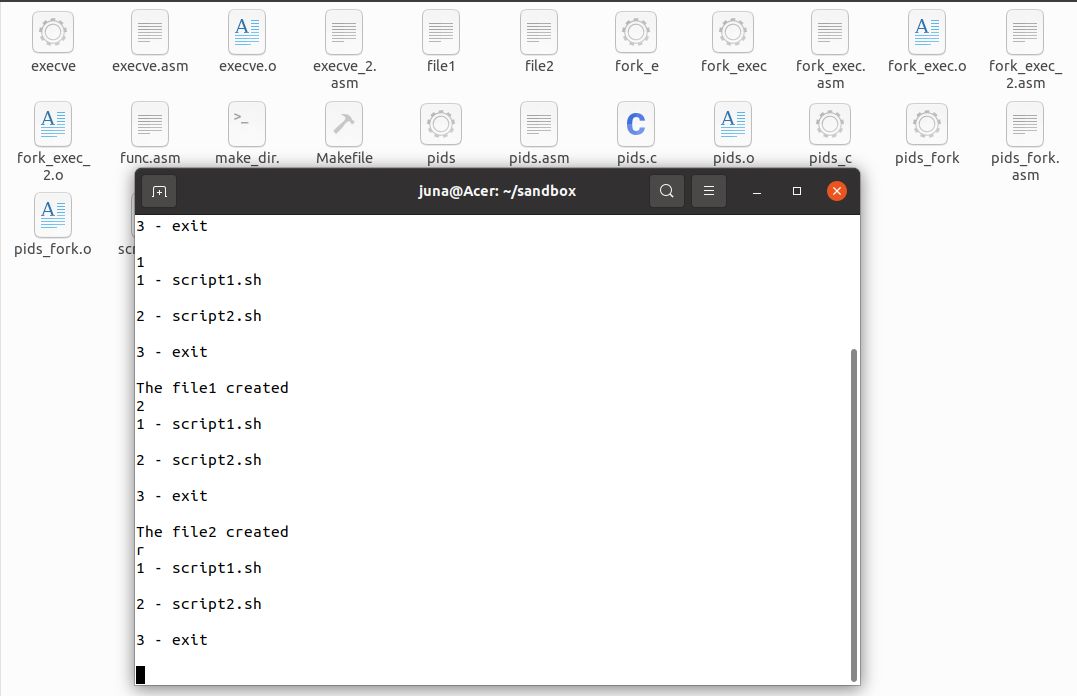

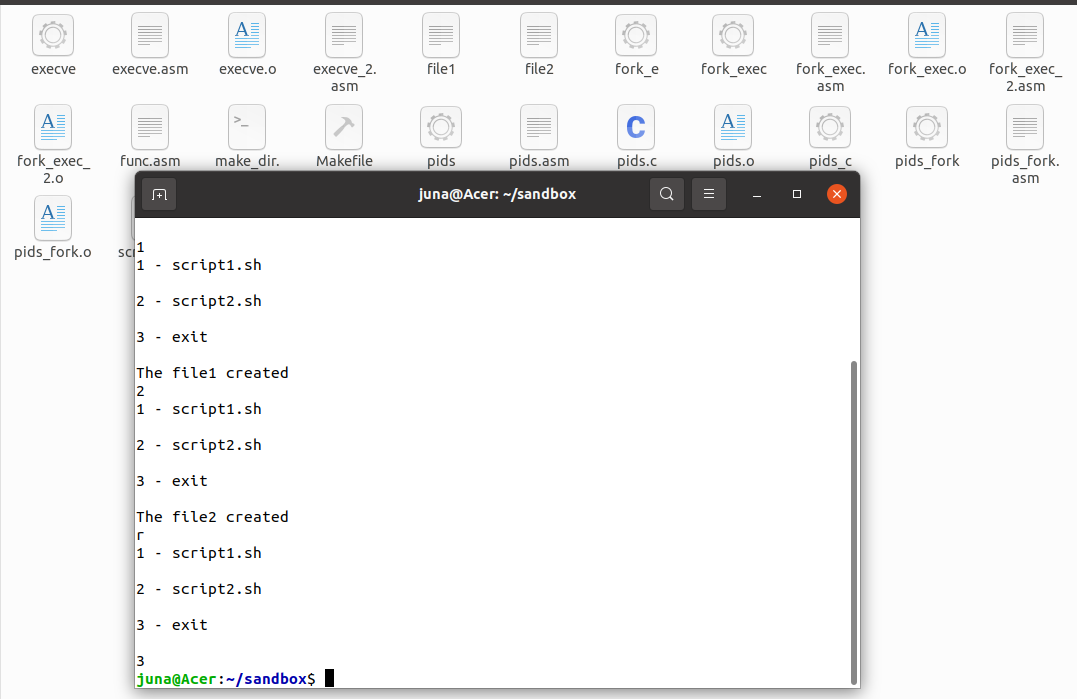

Разработаем теперь программу, которая будет ждать от пользователя ввода имени любой запускаемой программы без параметров, после ввода имени программы, родительский процесс создает fork, в котором запускает данную программу и продолжает ожидание следующей программы для запуска.

In [ ]:
	;; fork_exec_2.asm
	
	format elf64

	public _start


	include "func.asm"

	section '.data' writable
	
	msg db "Enter the name of program", 0xa, 0
	
	section '.bss' writable

	buffer rb 200
	
	section '.text' executable
	
_start:
	
   main_loop:
 
        mov rsi, msg
        call print_str
        call new_line 	

	mov rsi, buffer
	call input_keyboard

	mov rax, 57
	syscall
	cmp rax, 0
	jne main_loop
	mov rsi, 0
	mov rdi, buffer
	mov rax, 59
	syscall
   jmp main_loop

Ниже приведены скриншоты, демонстрирующие работоспособность программы:

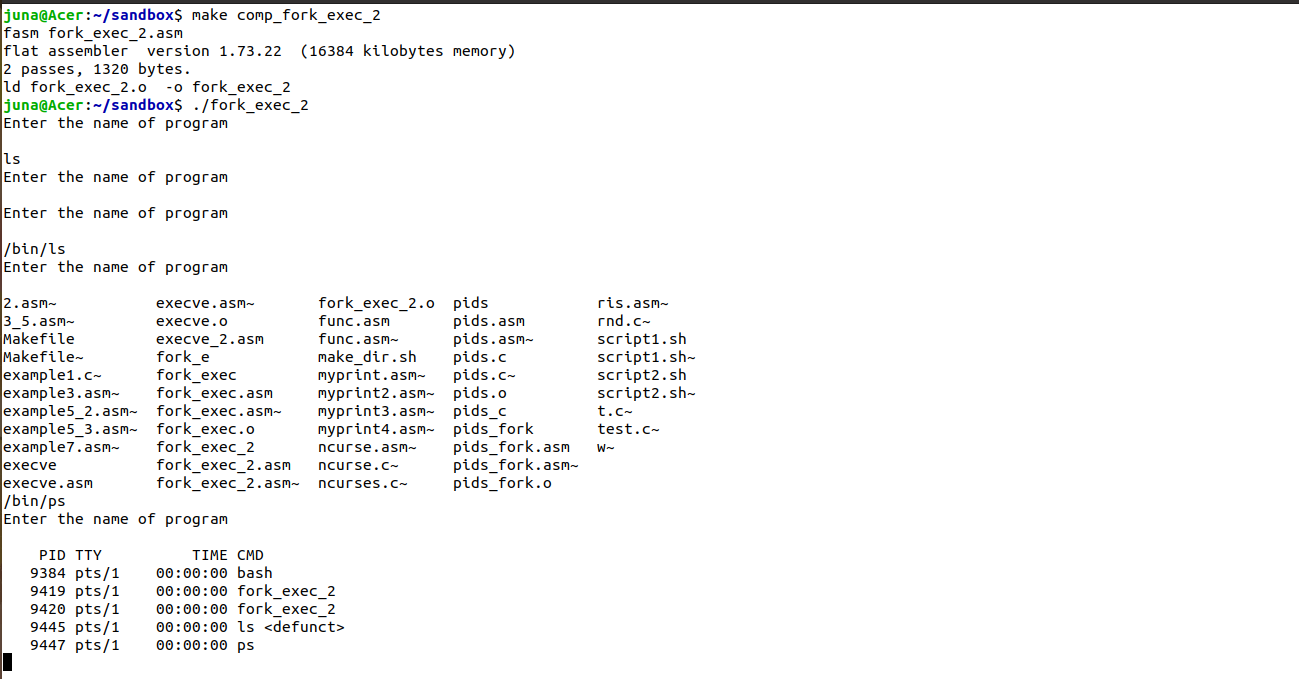



Как видно из скриншота, вначале введено имя программы ls, которой ничего не соответствует, потом запускается /bin/ls, затем /bin/ps. Последняя программа как раз показывает список активных процессов данного терминала. Как мы видим, имеется родительский процесс fork_exec_2 с pid=9419 и дочерний процесс с pid=9420. Следует также обратить внимание на процесс с pid=9445, он помечен как **defunct** - это **процесс зомби**.

**Дочерний процесс, который прервался, но чей предок пока не ожидает его завершения, называется зомби**. 


Процессы-зомби продолжают занимать некоторые системные  ресурсы. Эти ресурсы нужны, чтобы родительские процессы, желающие проверить статус своих потомков, получили информацию, относящуюся к существованию и прекращению данных процессов. Как только родительский процесс сделает это, ядро окончательно удаляет процесс-зомби.

Однако в Linux процессы-зомби возникают нередко. Эти процессы еще называются призраками, — дети безответственных родителей. Если ваше приложение ответвляет дочерний процесс, то оно несет ответственность за его обслуживание. 

Что происходит, если родительский процесс умирает раньше дочернего или если он завершается до того, как получит возможность позаботиться о своих потомках-зомби? Когда бы ни завершался процесс, ядро Linux проходится по списку его потомков и переназначает родительский процесс, делая их предком процесса systemd. Таким образом, ни один процесс не станет сиротой без родительского. 

Процесс systemd, в свою очередь, периодически заботится обо всех своих потомках, в результате чего ни один из них не остается
зомби чрезмерно долго. Следовательно, если родительский процесс завершается раньше своих потомков или не обсуживает их перед завершением, дочерние процессы переходят под опеку процесса systemd и обслуживаются им до полного завершения. 

Если более внимательно посмотреть в таблицу системных вызовов, то можно обнаружить такой системный вызов:

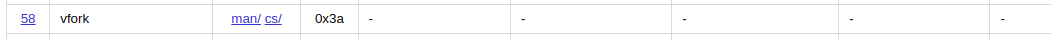

В ранних версиях UNIX ветвление было очень простым. После вызова ядро создавало копии всех структур внутренних данных, дублировало записи таблиц страницы процесса, а затем выполняло постраничное копирование родительского адресного пространства в дочернее. К сожалению, постраничное копирование — весьма затратный по времени процесс.

В современных системах UNIX подход усовершенствован. Вместо копирования всего объема родительского адресного пространства в современных системах UNIX, в том числе Linux, используются **страницы копирования при записи (COW)**.

**Копирование при записи** — это откладывающая стратегия оптимизации, разработанная для уменьшения нагрузки из-за дублирования процессов. Принцип весьма прост: если несколько пользователей запрашивают доступ для чтения их собственных копий ресурса, нет смысла дублировать создаваемые копии. Вместо этого каждый потребитель может получить указатель к одному и тому же ресурсу. Пока пользователи не пытаются изменить свою «копию» ресурса, сохраняется иллюзия эксклюзивного доступа к ресурсу и затрат на копирование не требуется. Если пользователь пытается редактировать свою копию ресурса, то в этот момент ресурс прозрачно дублируется и копия отправляется редактирующему пользователю. Потребитель, не видя происходящего, может изменять свою копию ресурса, пока другие продолжают просматривать оригинальную, неизмененную версию. Отсюда и название: копирование происходит только при записи.

Копирование при записи обладает еще одним преимуществом в процессе ветвления. Поскольку после ветвления чаще всего выполняется exec, копирование родительского адресного пространства в дочернее представляет собой пустую трату времени: ведь если дочерний процесс сразу же приступает к выполнению нового двоичного образа, его адресное пространство немедленно очищается. Копирование при записи избавляет и от этого неудобства.

Однако до внедрения страниц, поддерживающих копирование при записи, разработчики UNIX были вынуждены реализовывать бесполезное копирование адресного пространства в течение ветвления, сразу за которым следовало выполнение exec.
В связи с этим разработчики BSD представили в 3.0 BSD системный вызов, который называется **vfork**:

Успешное исполнение **vfork()** работает так же, как и **fork()**, кроме того, что дочерний процесс должен немедленно успешно вызвать одну из функций exec или завершиться.

**vfork()** не выполняет копирования адресного пространства родительского процесса, пока дочерний не завершится или не выполнит новый двоичный образ. Между этим родительский и дочерний процессы совместно используют — без семантики копирования при записи — свое адресное пространство и страницы с табличными записями. Следовательно, дочерний процесс не должен модифицировать никаких данных в памяти адресного пространства.

Системный вызов vfork() является архаизмом и не должен реализовываться в Linux, хотя, надо отдать должное, даже с учетом копирования при записи vfork() работает быстрее fork(), так как отпадает необходимость в самом копировании
страниц. 

Строго говоря, ни одно внедрение vfork() не застраховано от ошибок. 

## 5. Ожидание завершения дочернего процесса.

Если бы потомок по завершении полностью исчезал, то получение каких-либо сведений было бы для его предка невозможно.
Следовательно, первые разработчики UNIX решили, что когда дочерний процесс завершается прежде родительского, ядро должно поместить потомка в особый процессный статус -  **зомби**. 

В данном состоянии существует лишь «скелет» процесса — некоторые основные структуры данных, содержащие потенциально нужные сведения. 

Процесс в таком состоянии ожидает запроса о своем статусе от предка (процедура, известная как ожидание процесса-зомби). Только после того как предок получит всю необходимую информацию о завершенном дочернем процессе, последний формально удаляется и перестает существовать даже в статусе зомби.

Ядро Linux предоставляет несколько интерфейсов для получения информации о завершенном дочернем процессе.

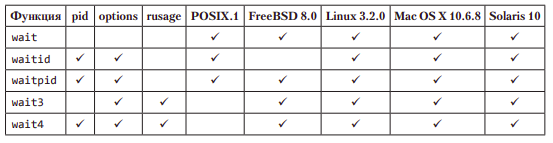

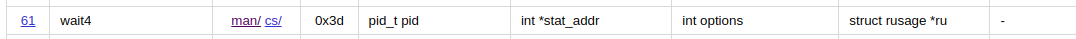



#include <sys/wait.h>

pid_t wait4(pid_t pid , int *_Nullable wstatus , int options ,  struct rusage *_Nullable rusage );

Данный системный вызов ожидает определенного дочернего процесса, указанного параметром pid и изменившего статус. 

Параметр options может передавать следующие значения с помощью логического «ИЛИ»:
- WCONTINUED - ждать завершения процесса, который возобновил работу после остановки и код состояния которого еще не был получен;
- WEXITED - получить информацию о состоянии завершившегося процесса;
- WNOHANG — не блокировать вызов, немедленно вернуть результат, если ни один подходящий процесс еще не завершился (остановился или продолжился);
- WNOWAIT - не уничтожать информацию о состоянии дочернего процесса, чтобы можно было получить;
- WSTOPPED - ждать завершения процесса, который был остановлен и код состояния которого еще не был получен.
В аргументе options должна быть указана хотя бы одна из констант: WCONTINUED, WEXITED или WSTOPPED.

Соответствие числовым значениям представлено в заголовочном файле **wait.h**:

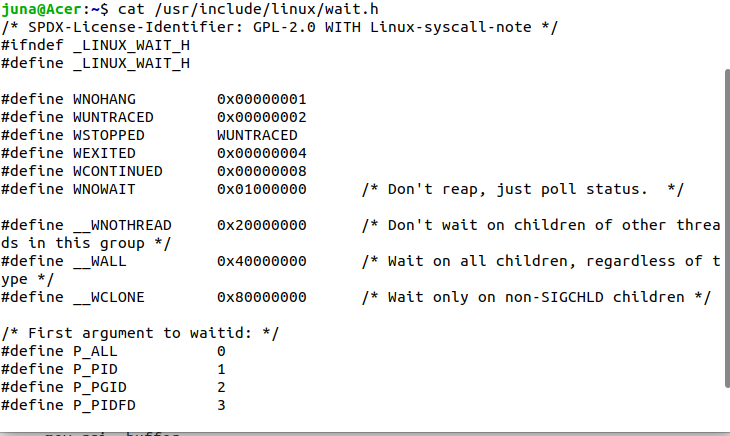

В случае успеха **wait4** возвращает pid процесса, статус которого изменился. Если установлен WNOHANG, а указанный дочерний процесс не изменил свой статус, **wait4** вернет 0. В случае ошибки вызов возвращает -1.

Если параметр **rusage** не NULL, функция заполняет указатель, прописанный в rusage, информацией о дочернем процессе. Эта структура предоставляет информацию об использовании ресурсов дочерним процессом:

In [ ]:
#include <sys/resource.h>
struct rusage {
 struct timeval ru_utime; /* затраченное пользовательское время */
 struct timeval ru_stime; /* затраченное системное время */
 long ru_maxrss; /* максимальный размер резидентной части */
 long ru_ixrss; /* размер общей памяти */
 long ru_idrss; /* размер собственных данных */
 long ru_isrss; /* размер собственного стека */
 long ru_minflt; /* восстановления страниц */
 long ru_majflt; /* страничные прерывания */
 long ru_nswap; /* операции подкачки */
 long ru_inblock; /* блочные операции ввода */
 long ru_oublock; /* блочные операции вывода */
 long ru_msgsnd; /* отправленные сообщения */
 long ru_msgrcv; /* полученные сообщения */
 long ru_nsignals; /* полученные сигналы */
 long ru_nvcsw; /* добровольные переключения контекста */
 long ru_nivcsw; /* вынужденные переключения контекста */
};

В программе ниже осуществляется ожидание завершения дочернего процесса.

In [ ]:
	;; fork_exec_3.asm
	
	format elf64

	public _start


	include "func.asm"

	section '.data' writable
	
	msg1 db "Enter the name of program", 0xa, 0
	msg2 db "The child process has terminated", 0xa, 0
	
	section '.bss' writable

	buffer rb 200
	status rd 1
	pid rq 1
	
	section '.text' executable
	
_start:	
        mov rsi, msg1
        call print_str
        call new_line 	

	mov rsi, buffer
	call input_keyboard

	mov rax, 57
	syscall
	cmp rax, 0
	jne wwait
	mov rsi, 0
	mov rdi, buffer
	mov rax, 59
	syscall
	call exit
	
   wwait:
        mov [pid], rax
        mov rcx, 1000000000
        mm:
        nop
        loop mm
        mov rdi, [pid]
        mov rsi, status
        mov rdx, 1
        mov r10, 0
        mov rax, 61
        syscall
        
        mov rsi, buffer
        xor rax, rax
        mov eax, [status]
        call number_str
        call print_str
        call new_line
  
        mov rsi, msg2
        call print_str
        call exit

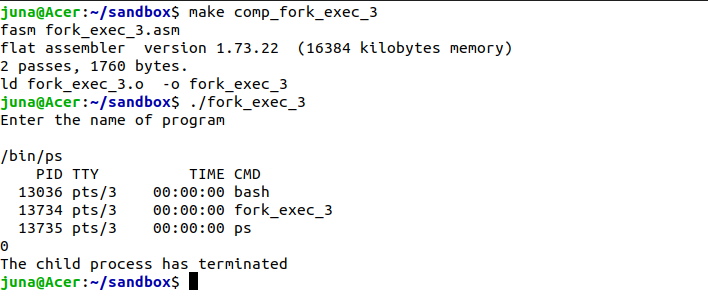

В коде следует обратить внимение на пустой цикл:

In [ ]:
mov rcx, 1000000000
        mm:
        nop
        loop mm

Он реализует задержку в родительском процессе, пока дочерний процесс успеет вывести информацию на экран. Если его убрать, поведение немного изменится:

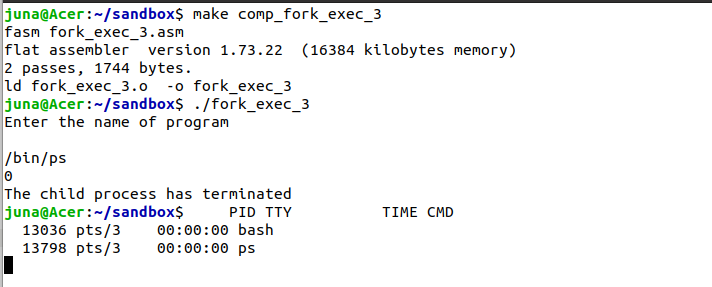

Видно, что родительский процесс успевает отработать быстрее, чем дочерний процесс выводит информацию в консоль. 